# Sub-clustering and LRP weight plot

In [2]:
import STACCI
from typing import List, Union, Literal

# Define input parameters directly or through interactive widgets
class Args:
    def __init__(self, root: str, ds_dir: str, ds_name: str,
                 h5_name: str, label_col_name: str, n_nei: int, target_types: List[str]=[],
                 bad_types: List[str]=[], n_clusters: int=-1, alpha: float=0.0, reso: float=None,
                 init: Union[Literal["one"], Literal["std"], Literal["re_sum"], Literal["sum"]]='one', 
                 gpu: int=0, use_gpu: bool=False, wo_anno: bool=False, region_col_name: str='NULL'):
        self.root = root
        self.ds_dir = ds_dir
        self.ds_name = ds_name
        self.h5_name = h5_name
        self.label_col_name = label_col_name
        self.target_types = target_types
        self.bad_types = bad_types
        self.n_nei = n_nei
        self.n_clusters = n_clusters
        self.alpha = alpha
        self.reso = reso
        self.init = init
        self.gpu = gpu
        self.use_gpu = use_gpu
        self.wo_anno = wo_anno
        self.region_col_name = region_col_name

# Usage:
test_args = Args(root='./tests/', ds_dir='datasets/', ds_name='10xv4_n0_v3', 
                 h5_name='10xv4_n0_v3_stringent_self', target_types=['Tumor_major'], 
                 gpu=1, use_gpu=True, n_nei=12, n_clusters=4, alpha=0.75,
                 label_col_name='cell_type', region_col_name='Region')

## Prepare args for sub-clustering

In [3]:
stcase_args = STACCI.prepare(test_args)

/home/tid/mambaforge/envs/stcase/lib/python3.10/site-packages/scanpy/preprocessing/_highly_variable_genes.py:72: UserWarning: `flavor='seurat_v3'` expects raw count data, but non-integers were found.


Boundary:  574.0109717404521

Average number of neighbor:  11.860615883306322

574.0109717404521 20890 8.464343598055105

<Figure size 640x480 with 0 Axes>

## Training GNN for sub-clustering

In [ ]:
STACCI.train(stcase_args)

## Plot results

>>> For Tumor_major spots


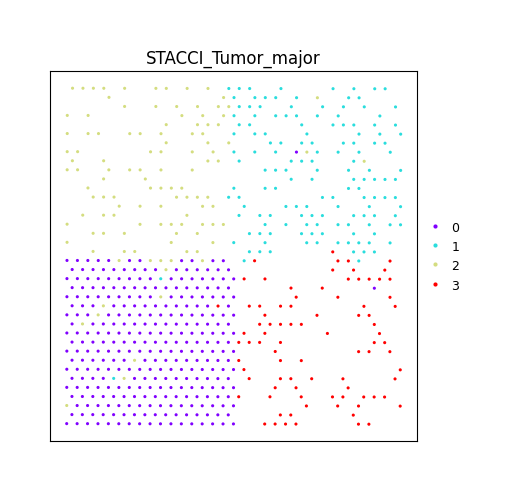

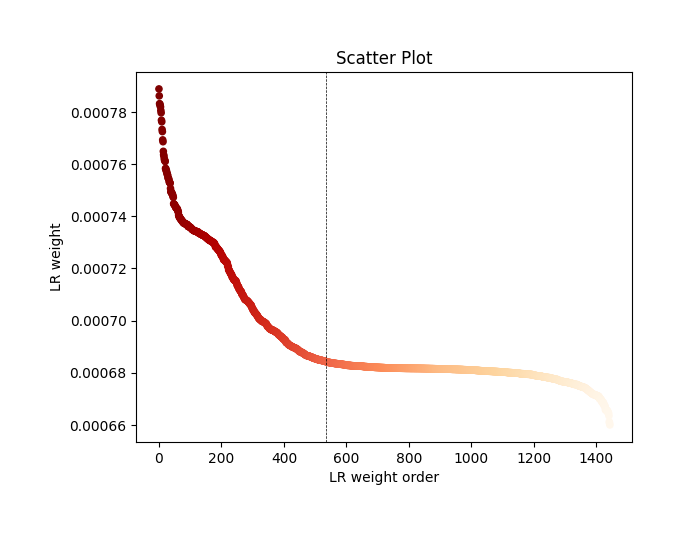

536


In [19]:
import copy
import numpy as np
import pandas as pd
import scanpy as sc
import anndata as ad
import os.path as osp
import matplotlib.pyplot as plt


meta_folder = osp.join(stcase_args.data_path, stcase_args.data_name)
types_set = np.loadtxt(
    osp.join(meta_folder, 'types_set.txt'), 
    delimiter='\t', 
    dtype=str
)
increment=0.02
for t in types_set:
    if t not in stcase_args.bad_types and t in stcase_args.target_types:
        print(f">>> For {t.replace('/', 'or')} spots")
        args = copy.deepcopy(stcase_args)
        gene_tag = f"hvg={'FULL' if args.use_whole_gene else args.n_input}"
        method = f"{t.replace('/', 'or')}_alpha={args.alpha}_reso={args.reso}_" + \
            f"cut={args.lr_cut}_{gene_tag}_nei={args.n_nei}"
        args.embedding_data_path = osp.join(
            args.embedding_data_path, 
            args.data_name, 
            method, 
            args.time_stamp
        )  # Tid: out
        result_path = osp.join(
            args.result_path, args.data_name, args.time_stamp, method
        )

        # Plot sub-clustering result
        generated_data_fold = osp.join('generated/', args.data_name)
        cell_types = pd.read_csv(osp.join(generated_data_fold, 'cell_types.csv')).iloc[:, 0]
        type_id_list = cell_types[cell_types == t].index.to_list()
        node_embed = np.load(osp.join(args.embedding_data_path, 'spot_embed.npy'))

        outdir = osp.join('results/', args.data_name, args.time_stamp, method)
        f = open(osp.join(outdir, f"fixed_n={args.n_clusters}_{t.replace('/', 'or')}_types.txt"))
        line = f.readline() # drop the first line  
        cell_cluster_type_list = []
        while line: 
            tmp = line.split('\t')
            cell_cluster_type = int(tmp[1].replace('\n', ''))
            cell_cluster_type_list.append(cell_cluster_type)
            line = f.readline()
        f.close()
        
        coordinates = np.load(osp.join(generated_data_fold, 'coordinates.npy'))[type_id_list]
        sc_cluster = plt.scatter(
            x=coordinates[:, 0], 
            y=-coordinates[:, 1], 
            s=5, 
            c=cell_cluster_type_list,
            cmap='rainbow'
        )
        plt.legend(
            *sc_cluster.legend_elements(), 
            bbox_to_anchor=(1, 0.5), 
            loc='center left', 
            prop={'size': 9}
        )
        plt.xticks([])
        plt.yticks([])
        plt.axis('scaled')
        plt.title(f"STACCI_{t}")
        plt.show()
        plt.clf()

        # Plot LRP weight
        df = pd.read_csv(osp.join(result_path, f'lr_weight.csv'))
        print(STACCI.tl.Inflection_point_finding(df, vis=True))